<a href="https://colab.research.google.com/github/Rama-vanapalli/MajorProject/blob/main/Copy_of_Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to your training and validation data
train_data_dir = '/content/drive/MyDrive/Dataset1/Lung segmentation/Train'
val_data_dir = '/content/drive/MyDrive/Dataset1/Lung segmentation/Val'

# Define image dimensions and batch size
img_width, img_height = 256, 256
batch_size = 32

# Define the data generator for training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# Define the data generator for validation data
val_datagen = ImageDataGenerator(rescale=1. / 255)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='input',
    shuffle=True)

# Create the validation data generator
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='input',
    shuffle=False)

def mean_io_u(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    iou = intersection / union
    return iou

def unet_vgg16(input_shape=(256, 256, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layers in base_model.layers[:-2]:
        layers.trainable=False

    encoder_layers = [
        base_model.get_layer('block1_conv2').output,
        base_model.get_layer('block2_conv2').output,
        base_model.get_layer('block3_conv3').output,
        base_model.get_layer('block4_conv3').output,
        base_model.get_layer('block5_conv3').output
    ]

    x = encoder_layers[-1]
    for layer in reversed(encoder_layers[:-1]):
        x = Conv2DTranspose(filters=layer.shape[-1], kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
        x = concatenate([layer, x], axis=-1)
        x = Conv2D(filters=layer.shape[-1], kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters=layer.shape[-1], kernel_size=(3, 3), activation='relu', padding='same')(x)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(x)  # Use sigmoid for binary classification

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Create U-Net with VGG16 base model
model = unet_vgg16()

# Print model summary
model.summary()

# Compile the model with MeanIoU metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_io_u])

# Directory where the checkpoints will be saved
checkpoint_dir = 'UNet_VGG16_Models/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a ModelCheckpoint callback to save the model at every improved epoch
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_mean_io_u_{val_mean_io_u:.4f}.h5'),
    monitor='val_mean_io_u',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False)

# Fit the model with the checkpoint callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint])


Found 3758 images belonging to 2 classes.
Found 932 images belonging to 2 classes.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
         

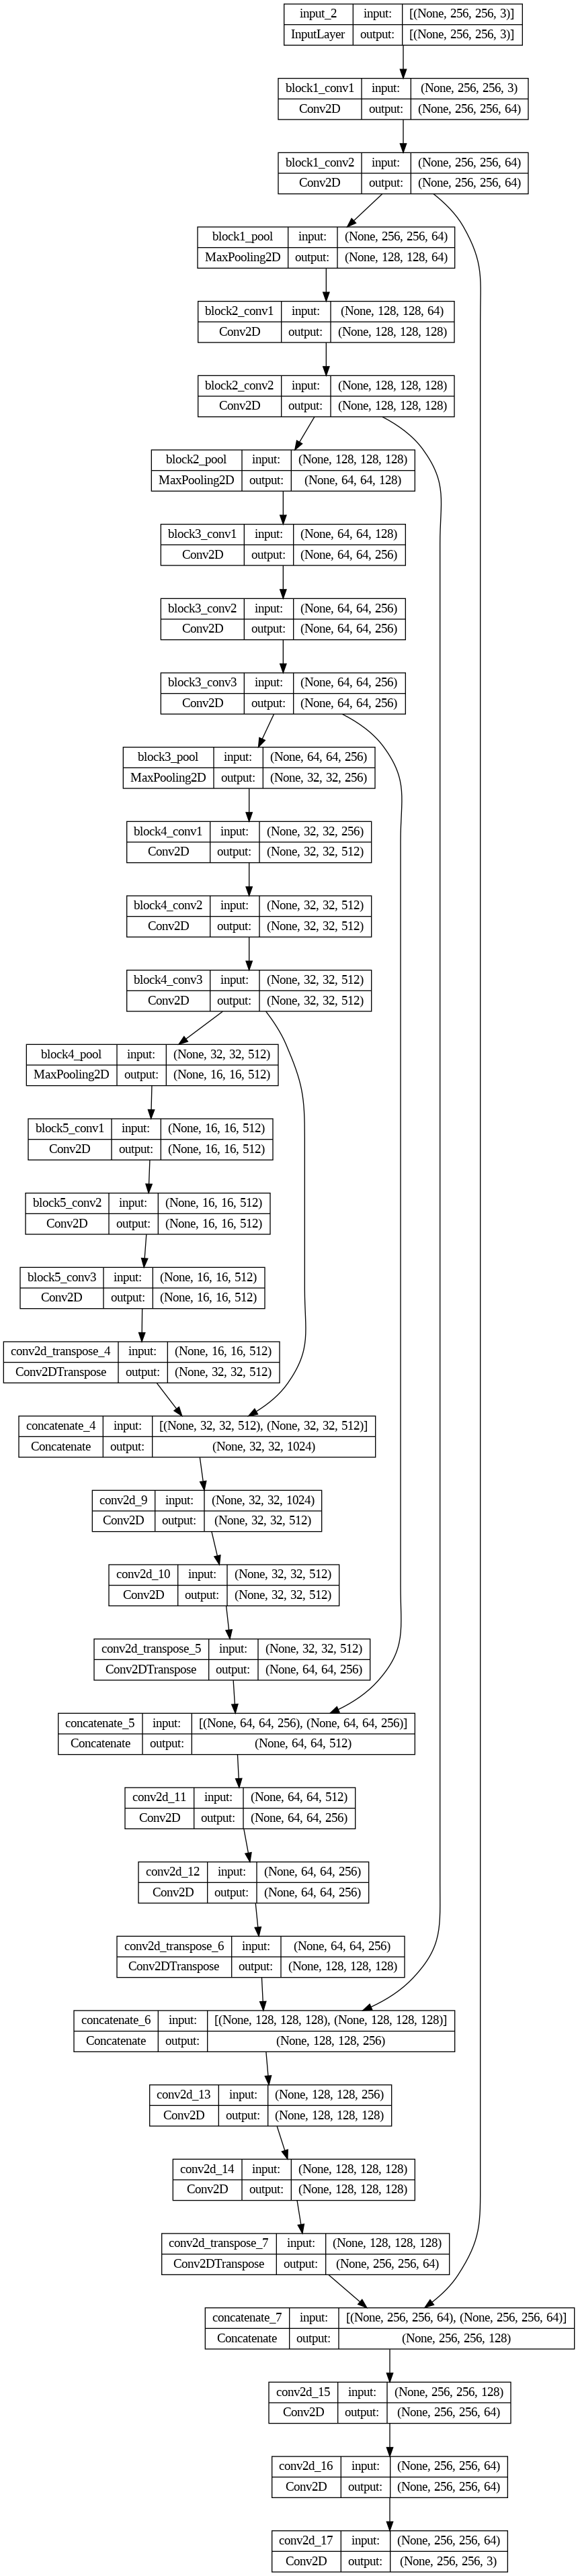

In [8]:
# Plot the model
from tensorflow.keras.utils import plot_model



#from keras.utils.vis_utils import plot_model
plot_model(model, to_file='unet_vgg16.png', show_shapes=True, show_layer_names=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install tensorflow